In [36]:
import os
import sys
import time
import math
import copy
import heapq
import random
import threading
import collections

import numpy as np

import pandas as pd
import tensorflow as tf
from sklearn import metrics
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

from matplotlib.ticker import MultipleLocator, FormatStrFormatter

In [37]:
def Get_Sapce(grid_array):
    
    arr_normalized=list()
    
    for arr in grid_array:
        
        arr_normalized+=arr
        
    return list(set(arr_normalized))

        
def Grid_normalize(arr):
    
    arr=arr.replace('[','')

    arr=arr.replace(']','')

    arr=arr.replace("'",'')

    arr=arr.replace(" ",'')

    arr=arr.split(',')
    
    if '' in arr:
        
        arr.pop(arr.index(''))
    
    return arr
    
def Encode(arr,One_encode):
    
    encode=list()
    
    for g in arr:
        
        encode.append(One_encode[g])
        
    return encode

'''Get batch index'''

def Get_batch(df,batch_size=128):
    
    batch_index=[]
    
    for i in range(batch_size,len(df)+batch_size,batch_size):
        
        batch_index.append(i)
        
    return batch_index


In [38]:
'''Load data'''

Df = pd.read_csv('./data/train_data.csv')

Df = Df.drop(columns='Unnamed: 0')

Df = Df[['TRIP_ID','Grids','label']]

Df['Grids'] = Df.apply(lambda x:Grid_normalize(x['Grids']),axis=1)

Grid_space = Get_Sapce(list(Df['Grids']))

One_encode = {Grid_space[i]:i for i in range(len(Grid_space))}

Df['Encode'] = Df.apply(lambda x:Encode(x['Grids'],One_encode),axis=1)

Df = Df.sample(frac=1)

Df = Df.reset_index(drop=True)

Df['Length']=Df.apply(lambda x:len(x['Encode']),axis=1)

Df=Df.loc[Df['Length']>0]

max_length=Df['Length'].max()

vocab_size=len(One_encode)

Df['Encode'] = Df.apply(lambda x:x['Encode']+[0]*(max_length-len(x['Encode'])) if len(x['Encode'])<max_length else x['Encode'],axis=1)

Df['neg_label']=Df.apply(lambda x:1-x['label'],axis=1)

Df



,TRIP_ID,Grids,label,Encode,Length,neg_label
0,1387118734620000674,"[8a39220f1297fff, 8a39220f174ffff, 8a39220f176...",0,"[378, 658, 629, 66, 679, 1231, 672, 1131, 621,...",29,1
1,1379648806620000624,"[8a39220f020ffff, 8a39220f0277fff, 8a39220f034...",0,"[665, 1059, 411, 794, 69, 1253, 1152, 395, 531...",14,1
2,1396187806620000525,"[8a39220f1297fff, 8a39220f174ffff, 8a39220f174...",1,"[378, 658, 1077, 578, 1141, 679, 1231, 454, 62...",28,0
3,1397087262620000506,"[8a39220f020ffff, 8a39220f0207fff, 8a39220f00e...",1,"[665, 1126, 801, 89, 761, 960, 377, 826, 960, ...",20,0
4,1402960913620000395,"[8a39220f020ffff, 8a39220f0277fff, 8a39220f026...",0,"[665, 1059, 1063, 411, 203, 794, 1253, 1179, 5...",24,1
6,1373974160620000224,"[8a39220f020ffff, 8a39220f021ffff, 8a39220f021...",0,"[665, 138, 1009, 1126, 1059, 1063, 590, 411, 4...",24,1
7,1374699645620000514,"[8a39220f020ffff, 8a39220f00effff, 8a39220f001...",1,"[665, 649, 835, 783, 761, 129, 633, 960, 633, ...",24,0
8,1398475639620000305,"[8a39220f020ffff, 8a39220f0277fff, 8a39220f034...",1,"[665, 1059, 411, 69, 203, 794, 1253, 1152, 43,...",45,0
9,1396927189620000307,"[8a39220f020ffff, 8a39220f0277fff, 8a39220f035...",0,"[665, 1059, 590, 411, 203, 794, 1179, 405, 989...",17,1
10,1401030235620000020,"[8a39220f020ffff, 8a39220f0207fff, 8a39220f00e...",0,"[665, 1126, 801, 835, 783, 761, 960, 377, 1218...",25,1


In [39]:
'''Configurration of RNN'''

class Config(object):
    
    '''(1) Embedding size'''
    
    embedding_dim = 128
    
    '''(2) Sequence length'''
    
    seq_length = 1000
    
    '''(3) Sequence length'''
    
    num_classes = 2
    
    '''(4) Word length'''
    
    vocab_size = 5000
    
    '''(5) Encoder Output size'''
    
    encoder_hidden_dim = 64
    
    '''(6) Attention size'''
    
    attention_size = 48
    
    '''(7) Decoder Output size'''
    
    decoder_hidden_dim = 48
    
    '''(8) Drop out keep prob'''
    
    dropout_keep_prob = 0.5
    
    '''(9) Learning rate '''
    
    learning_rate =  1e-4

    '''(10) Batch size'''
    
    batch_size = 32
    
    '''(11) Itration size'''
    
    num_epochs = 100
    
    
config = Config()

config.seq_length = max_length

config.vocab_size = len(One_encode)   

Framework.png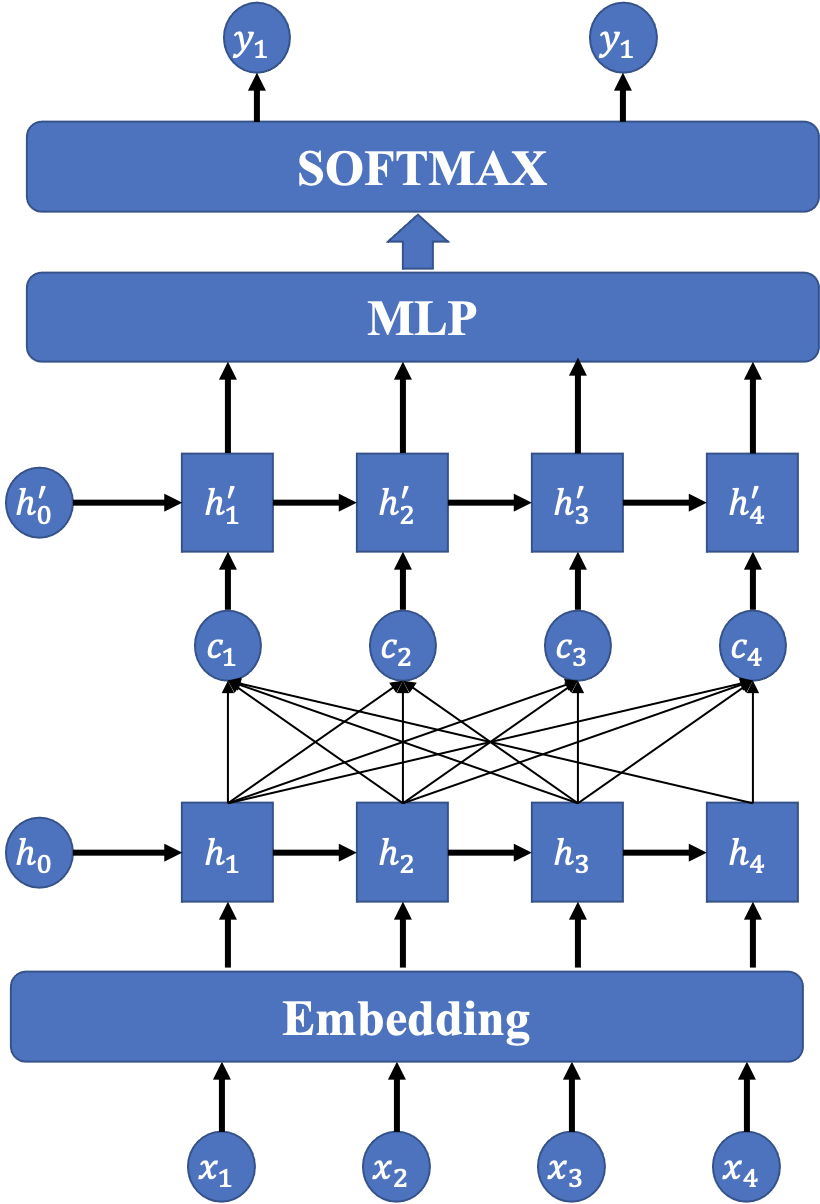

In [40]:
class Detection(object):
    
    def __init__(self, config):
        
        self.config = config
        self.input_x = tf.placeholder(tf.int32, [None, self.config.seq_length])
        self.seq_length = tf.placeholder(tf.int32, [None])
        self.input_y = tf.placeholder(tf.float32, [None, self.config.num_classes])
        self.keep_prob = tf.placeholder(tf.float32, [], name="keep_prob")
        self.Embedding()
        self.Encoder()
        self.Attention()
        self.Decoder()  
        self.MLP()
        self.OPT()
        self.ACC()
        
    def Embedding(self):

        # Input size: batch_size * seq_length, i.e. 10*543
        
        # Out size: batch_size * seq_length * embedding_size , i.e. 128*543*128

        self.embeddings = tf.Variable(tf.random_uniform([self.config.vocab_size, self.config.embedding_dim], -1.0, 1.0), dtype=tf.float32)
        
        self.encoder_inputs_embedded = tf.nn.embedding_lookup(self.embeddings, self.input_x)
        
    def Encoder(self):
        
        # Input size: batch_size * seq_length * embedding_size , i.e. 128*543*128
        
        # Out size: 
        
        # (1) encoder_outputs: batch_size * seq_length * encoder_hidden_dim, i.e. 10*543*64
        
        # (2) encoder_final_state: batch_size * encoder_hidden_dim, i.e. 10*64
        
        with tf.variable_scope("encoder",reuse=tf.AUTO_REUSE):
            
            encoder_cell = tf.nn.rnn_cell.GRUCell(self.config.encoder_hidden_dim)
            
            self.encoder_outputs, self.encoder_final_state = tf.nn.dynamic_rnn(
                encoder_cell,\
                self.encoder_inputs_embedded,\
                sequence_length=self.seq_length,\
                dtype=tf.float32)
            
    def Attention(self):
        
        # Input size: batch_size * seq_length * hidden_dim, i.e. 10*543*64
        
        
        self.attention_mechanism = tf.contrib.seq2seq.BahdanauAttention(num_units=self.config.attention_size,\
                                                                        memory= self.encoder_outputs,\
                                                                        normalize=True)
        
        
    def Decoder(self):
        
        # Input size: batch_size * seq_length * hidden_dim, i.e. 10*543*64
        
        # Out size: 
        
        # (1) encoder_outputs: batch_size * seq_length * decoder_hidden_dim, i.e. 10*543*48
        
        # (2) encoder_final_state: batch_size * decoder_hidden_dim, i.e. 10*48
        
        with tf.variable_scope("decoder",reuse=tf.AUTO_REUSE):
            
            decoder_cell = tf.nn.rnn_cell.GRUCell(self.config.decoder_hidden_dim)
            
            decoder_cell = tf.contrib.seq2seq.AttentionWrapper(cell=decoder_cell,\
                                                               attention_mechanism=self.attention_mechanism,
                                                               attention_layer_size=self.config.attention_size,\
                                                               name='Attention_Wrapper')
            self.decoder_outputs, self.decoder_final_state = tf.nn.dynamic_rnn(
                decoder_cell,\
                self.encoder_outputs,\
                sequence_length=self.seq_length,\
                dtype=tf.float32)
            
    def MLP(self):
        
        with tf.variable_scope("MLP",reuse=tf.AUTO_REUSE):
            
            fc = tf.layers.dense(self.decoder_final_state[0], self.config.decoder_hidden_dim, name='fc1')
            fc = tf.nn.sigmoid(fc)
            self.logits = tf.layers.dense(fc, self.config.num_classes, name="fc2")
            
        with tf.variable_scope("Score",reuse=tf.AUTO_REUSE):
            
            self.y_outputs=self.logits
        
            self.y_pred_cls = tf.argmax(tf.nn.softmax(self.y_outputs), 1)
            
    def OPT(self):
        
        with tf.variable_scope("optimize",reuse=tf.AUTO_REUSE):
            cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits=self.y_outputs, labels=self.input_y)
            self.loss = tf.reduce_mean(cross_entropy)
            self.optim = tf.train.AdamOptimizer(learning_rate=self.config.learning_rate).minimize(self.loss)
            
    def ACC(self):
        
        with tf.variable_scope("accuracy",reuse=tf.AUTO_REUSE):
            correct_pred = tf.equal(tf.argmax(self.input_y, 1), self.y_pred_cls)
            self.acc = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        

In [41]:
model = Detection(config)

In [42]:
'''Load data'''

Train_df=Df.iloc[:800]

Test_df=Df.iloc[800:]

'''Train data'''

Train_data=np.array([np.array(x) for x in list(Train_df['Encode'])])

Train_label=np.array(Train_df[['neg_label','label']])

Train_length=np.array(Train_df['Length'])


'''Test data'''
                

Test_data=np.array([np.array(x) for x in list(Test_df['Encode'])])

Test_label=np.array(Test_df[['neg_label','label']])

Test_length=np.array(Test_df['Length'])




In [44]:
with tf.Session(config=tf.ConfigProto(allow_soft_placement=True,  log_device_placement=True)) as sess:
    
    sess.run(tf.global_variables_initializer())
    
    LOSS=list()
    
    ACC=list()
    
    for i in range(model.config.num_epochs):
        
        print('Iteration: ',i)
        
        '''Random Sampling'''
        indics = np.random.permutation(len(Train_data))
        Train_data = Train_data[indics]
        Train_label = Train_label[indics]
        Train_length = Train_length[indics]
        Iteration=int(np.ceil(len(Train_data)/float(model.config.batch_size)))
        
        '''Initialize list'''
        loss_array=list()
        acc_array=list()
        
        '''Batch Training'''
        
        for i in range(Iteration):
            start = i * model.config.batch_size
            end = min(start+model.config.batch_size, len(Train_data))
            batch_x=Train_data[start:end]
            batch_y=Train_label[start:end]
            batch_length=Train_length[start:end]

            _loss, _ = sess.run([model.loss, model.optim], feed_dict={
                    model.input_x: batch_x,
                    model.input_y: batch_y,
                    model.keep_prob: model.config.dropout_keep_prob,
                    model.seq_length: batch_length
                })
                
            _acc = sess.run([model.acc], feed_dict={
                model.input_x: batch_x,
                model.input_y: batch_y,
                model.keep_prob: model.config.dropout_keep_prob,
                model.seq_length: batch_length
            })

            loss_array.append(_loss)
            acc_array.append(_acc)
            
        mean_loss=np.array(loss_array).mean()
        mean_acc=np.array(acc_array).mean()
        
        LOSS.append(mean_loss)
        ACC.append(mean_acc)

        
np.save('LOSS.npy',LOSS)

np.save('ACC.npy',ACC)

Iteration:  0
Iteration:  1
Iteration:  2
Iteration:  3
Iteration:  4
Iteration:  5
Iteration:  6
Iteration:  7
Iteration:  8
Iteration:  9
Iteration:  10
Iteration:  11
Iteration:  12
Iteration:  13
Iteration:  14
Iteration:  15
Iteration:  16
Iteration:  17
Iteration:  18
Iteration:  19
Iteration:  20
Iteration:  21
Iteration:  22
Iteration:  23
Iteration:  24
Iteration:  25
Iteration:  26
Iteration:  27
Iteration:  28
Iteration:  29
Iteration:  30
Iteration:  31
Iteration:  32
Iteration:  33
Iteration:  34
Iteration:  35
Iteration:  36
Iteration:  37
Iteration:  38
Iteration:  39
Iteration:  40
Iteration:  41
Iteration:  42
Iteration:  43
Iteration:  44
Iteration:  45
Iteration:  46
Iteration:  47
Iteration:  48
Iteration:  49
Iteration:  50
Iteration:  51
Iteration:  52
Iteration:  53
Iteration:  54
Iteration:  55
Iteration:  56
Iteration:  57
Iteration:  58
Iteration:  59
Iteration:  60
Iteration:  61
Iteration:  62
Iteration:  63
Iteration:  64
Iteration:  65
Iteration:  66
Itera

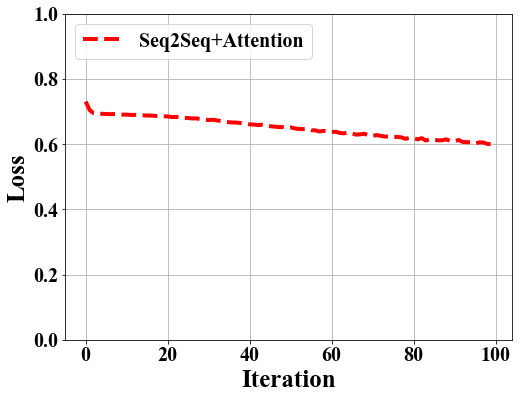

In [45]:
ACC=np.load('ACC.npy',allow_pickle=True)

LOSS=np.load('LOSS.npy',allow_pickle=True)


'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.plot(list(range(len(LOSS))),LOSS,'r--',linewidth=4,alpha=1,label='Seq2Seq+Attention')


ax1.set_ylabel('Loss',font_label)

ax1.set_xlabel('Iteration',font_label)

ax1.legend(loc = 'upper left',prop=font_legend)


ax1.set_ylim([0,1.0])

plt.grid()

plt.show()

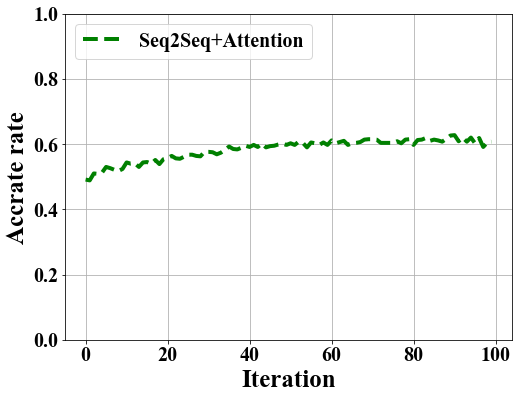

In [46]:



'''Plot'''

'''Figure'''

figsize = 8,6

font_label = {'family' : 'Times New Roman','weight' : 'normal','size': 25}

font_legend = {'family' : 'Times New Roman','weight' : 'normal','size': 20}



figure, ax1 = plt.subplots(figsize=figsize)

labels = ax1.get_xticklabels() + ax1.get_yticklabels()

[label.set_fontsize(20) for label in labels]

[label.set_fontname('Times New Roman') for label in labels]

l0=ax1.plot(list(range(len(ACC))),ACC,'g--',linewidth=4,alpha=1,label='Seq2Seq+Attention')


ax1.set_ylabel('Accrate rate',font_label)

ax1.set_xlabel('Iteration',font_label)

ax1.legend(loc = 'upper left',prop=font_legend)


ax1.set_ylim([0,1.0])

plt.grid()

plt.show()